# Clustering Trajectories
In this best practices notebook, we will illustrate how one can apply clustering to a molecular dynamics (MD) trajectory of aspirin in order to identify different conformers.

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## K-means clustering
If you are interested in the k-means clustering algorithm, you can explore the function `kmeans` implemented below. Alternatively, you can use the implementation provided by scikit-learn (`sklearn.cluster.KMeans`). We summarize the algorithm below:

**The k-means algorithm:**
1. Randomly pick k centers (or centroids) among all the data points.
2. Assign each data point to its nearest center, forming an initial set of clusters.
3. Refine the clusters: for each cluster, compute its new center as the average of all data points in the cluster.
4. Repeat steps 2 and 3 until convergence; convergence is achieved when the assignments no longer change, i.e., the new cluster centers are the same as the previous ones.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def kmeans(data, k):
    """
    Perform K-means clustering on a given dataset.

    Args:
        data (numpy.ndarray): The input data array with shape (number of patterns, number of features).
        k (int): The number of clusters to form.

    Returns:
        numpy.ndarray: The resulting labels of each pattern, indicating the cluster it belongs to.
        int: The number of iterations taken to converge.
    """
    from scipy.spatial import distance_matrix

    npatt, nfeat = data.shape

    # 1. Randomly pick k centers (centroids)
    centroids = np.zeros((k, nfeat))
    inds = np.random.choice(npatt, k, replace=False)
    for i in range(k):
        centroids[i, :] = data[inds[i], :]

    # 2. Assign each point to its nearest center
    distances = distance_matrix(data, centroids)
    z = np.zeros(npatt) # Initialize cluster assignments
    zold = np.zeros(npatt) # Track previous cluster assignments
    z = np.argmin(distances, axis=1) # Assign clusters based on minimum distance

    icount = 0
    while np.any(np.not_equal(z, zold)):
        zold = z.copy()
        # 3. Update the k cluster centroids based on the assigned cluster membership
        for i in range(k):
            inds = np.where(z == i)
            centroids[i, :] = np.mean(data[inds], axis=1)

        # Recompute distances and reassign clusters
        distances = distance_matrix(data, centroids)
        z = np.argmin(distances, axis=1)
        icount += 1

    return z, icount

## Walk-through example: clustering a molecular dynamics trajectory of aspirin
For this example, we will use the ASE (Atomic Simulation Environment) library. ASE can be used for setting up, manipulating, running, and analyzing atomistic simulations. It provides tools for working with atomic structures and interfacing with various computational chemistry and materials science software packages.

In [3]:
from ase import Atoms

Next, we will mport the data, in this case an npz file of a molecular dynamics trajectory for aspirin. 

The full trajectory can be downloaded from [quantum-machine.org/gdml/data/npz/](http://quantum-machine.org/gdml/data/npz/) (filename *md17_aspirin.npz*). Download it and put in folder [../data](../data/) with same name 

Below, we will just use a reduced subset of the trajectory, called [../data/md17_aspirin_10000.npz](../data/md17_aspirin_10000.npz).

In [4]:
# Load the dataset containing the short MD trajectory for aspirin
data = np.load("../data/md17_aspirin_10000.npz")
# data = np.load("../data/md17_aspirin.npz")  # (or the longer one, if you prefer)

# Define the step size for sampling the data
step = 10

# Extract coordinates for each timestep, sampled according to the step size
R = data['R'][::step]

# Determine the number of timesteps and atoms from the shape of the coordinates array
n_steps, n_atoms, _ = R.shape
print(f'Total of {R.shape[0]} steps for {n_atoms} atoms')

# Extract atomic numbers for each atom
z = data['z']

# Extract and mean-center the energies for each sampled timestep (we are saving this for later use)
E = data['E'][::step]-np.mean(data['E'][::step])

Total of 1000 steps for 21 atoms


We will perform clustering on the geometrical information provided in the dataset. We are only given the atomic coordinates at each timestep as:
```
(n_steps, n_atoms, 3)
```

However, we have to encode the geometry in a way that is rotational and translationally invariant. The easiest way to accomplish this is by using all pairwise distances between our atoms at each timestep.

In [5]:
# Pairwise distances could easily be computed using our own custom functions,
# but we'll use ASE here

# Create a list of ASE atom objects using the coordinates and atomic numbers in the dataset
atoms = [Atoms(positions=r, numbers=z) for r in R]

# ASE gives a full distance matrix, but we only need every pair once (and ignore the diagonal).
# Hence, we will index only the upper/lower triangle
triangle_indices = np.tril_indices(n_atoms, k=-1)

# Generate the distances
distances = [x.get_all_distances()[triangle_indices] for x in atoms]
distances = np.array(distances)
print(f"Distance descriptor generated of shape: {distances.shape}")

Distance descriptor generated of shape: (1000, 210)


We are now ready to cluster our data. Choosing the number of clusters to create is an art in-and-of itself. 

For the purpose of this tutorial, we will use a metric called the *silhouette score* to point us in the right direction. 

In short, the silhouette score is a score telling us the 'quality' of clusters given a descriptor. This means that we first need to generate clusters for a given number (here, from k=2-10), and then we will settle on the values of k which gives the best score.

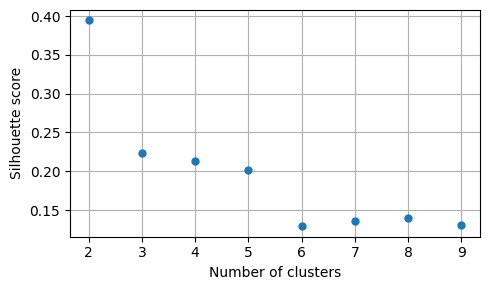

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters_list = np.arange(2,10)
sil_scores = []  # Where we'll save the scores
labels_list = []  # Where we'll save the labels

for n_clusters in n_clusters_list:
    km = KMeans(n_clusters=n_clusters)
    labels = km.fit_predict(distances)
    score = silhouette_score(distances, labels)

    sil_scores.append(score)
    labels_list.append(labels)

plt.figure(figsize=(5,3))

plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 10

plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.plot(n_clusters_list, sil_scores,'.')
plt.grid()

plt.tight_layout()

In our case, using 2 clusters seems to give the best silhouette score. 

💡 Note, however that the notion of what makes a particular clustering 'better' than another is vague and highly dependent on the specific application. In most cases, knowledge of the system at hand should be applied to determine the clustering quality.

Now that we have selected k=2, we can proceed with analyzing our clusters. Since the dataset provides energies as well as geometric information, we can see if the energy distribution varies from one cluster to the other. 

Note that while we will continue with 2 clusters below, the code below is written generally such that you can play around with the variable `n_clusters`.

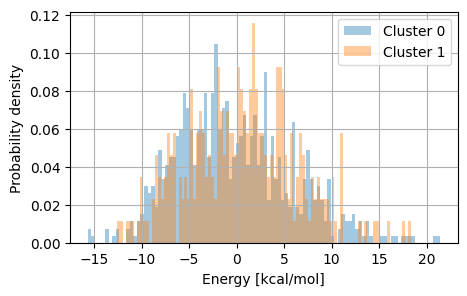

In [23]:
n_clusters = 2
labels = labels_list[n_clusters-2]

# For each cluster, create an energy subset and plot the distribution
plt.figure(figsize=(5, 3))
plt.rcParams['font.size'] = 10

for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    ei = E[cluster_idxs]
    plt.hist(ei, bins=100, alpha=0.4, density=True, label=f'Cluster {i}')

plt.legend()
plt.ylabel("Probability density")
plt.xlabel("Energy [kcal/mol]")
plt.grid()


Overall, there is a very slight shift in energy distribution from cluster to cluster. 

However, it makes sense that the cluster label of a point (MD state) will not be a strong indicator for its energy, as predicting the potential energy surface from the geometry of a molecule is a highly complex task for which significantly more elaborate (and supervised) methods are required.

That being said, the two clusters have in fact split the dataset into meaningfully different parts. To prove this, we will look at the dihedral angle between the benzene ring and the carboxylic group attached to it. This is one of the major ways this molecule can rotate, and it takes various values throughout the reference trajectory.

In [27]:
from ase.visualize import view

frame_indices = []

# For each cluster, get the indices of atoms in the first frame
for i in range(n_clusters):
    frame_indices.append(np.where(labels == i)[0][0])

# Let's see what the frame in the first cluster looks like
i=0
view(atoms[frame_indices[i]], viewer='x3d')

Text(0, 0.5, 'Probability density')

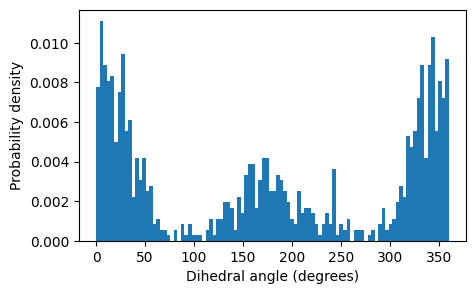

In [31]:
# Indices of atoms in the dihedral angle between the phenyl ring and carboxylic group
dihedral_indices = [6, 5, 10, 7]

# Calculate the dihedral angles
dihedrals = np.array([x.get_dihedral(*dihedral_indices) for x in atoms])

# Create a histogram of the dihedral angels visited in the entire trajectory
plt.figure(figsize=(5,3))
plt.hist(dihedrals, bins=100, density=True)
plt.xlabel("Dihedral angle (degrees)")
plt.ylabel("Probability density")

Throughout the entire trajectory, the dihedral angle spends most of its time around 360 and 180 degrees, as indicated by the well-defined peaks above. 

Let's now plot the same dihedral angle but for each cluster separately.

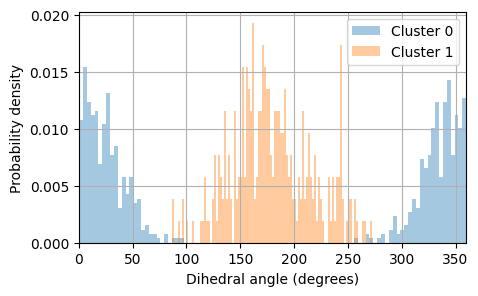

Relative populations of the clusters:  [0.721 0.279]


In [33]:
# For each cluster, create a dihedral subset and plot the distribution
populations = []

plt.figure(figsize=(5,3))
plt.rcParams['font.size'] = 10

for i in range(n_clusters):
    cluster_idxs = np.argwhere(labels == i).flatten()
    populations.append(len(cluster_idxs))
    dih = dihedrals[cluster_idxs]
    plt.hist(dih, bins=100, alpha=0.4, density=True, label=f'Cluster {i}')

plt.xlabel("Dihedral angle (degrees)")
plt.ylabel("Probability density")
plt.xlim([0, 360])
plt.legend()
plt.grid()
plt.show()

print('Relative populations of the clusters: ', populations/np.sum(populations))

With two clusters, we see a very good separation between the two dihedral peaks for each cluster! In other words, the above plot shows that the two different clusters do represent qualitatively different geometries. 

If you redo this analysis but with a higher number of clusters, you will find that there is a greater overlap in angles for this particular dihedral between the frames in the different clusters. Hhowever, other geometric properties not shown here would be different.